# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import pandas as pd
from functools import reduce
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, FloatType
from pyspark.sql import functions as F
from pyspark.sql.functions import isnan, when, count, col, countDistinct, udf
import matplotlib.pyplot as plt

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, GBTClassifier, RandomForestClassifier, DecisionTreeClassifier

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

import random
from datetime import datetime
import seaborn as sns

random.seed(10)
sns.set()

In [2]:
# create a Spark session
spark = SparkSession.builder.appName('Sparkify Project').getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
def loadData(spark = spark, path = 'mini_sparkify_event_data.json'):
    data = spark.read.json(path)
    return data

sparkifyData = loadData()

In [4]:
sparkifyData.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
# Count null values per column
sparkifyData.select([count(when(col(var).isNull(), var)).alias(var) for var in sparkifyData.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [6]:
# Counting the number of rows without a user
sparkifyData.filter("userId = ''").count()

8346

In [7]:
# Removing the rows where there is no user id
sparkifyData = sparkifyData.filter("userId != ''")

In [8]:
# Count null values per column
sparkifyData.select([count(when(col(var).isNull(), var)).alias(var) for var in sparkifyData.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



**Comment:**
Removing the rows without a user ID removed the rows that had null values previously. The rows that still have null values are actions that are not related to specific songs, therefore, no song title, artiste, or length is available. These columns won't be used for our predictions therefore we will ignore them for now. 

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [9]:
print(f'Total number of distinct users: {sparkifyData.agg(countDistinct(col("userId")).alias("count")).toPandas()["count"][0]}')

Total number of distinct users: 225


In [10]:
# Defining churn
defineChurn = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
sparkifyData = sparkifyData.withColumn('churn', defineChurn(sparkifyData.page))

In [11]:
# Transforming timestamps into dates and week numbers.
getDate = udf(lambda x: datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d"))
getWeek = udf(lambda x: datetime.fromtimestamp(x / 1000.0).isocalendar()[1], IntegerType())
getChurnWeek = udf(lambda x, y: datetime.fromtimestamp(x / 1000.0).isocalendar()[1] 
                   if y == 'Cancellation Confirmation' else 0 , IntegerType())

sparkifyData = sparkifyData.withColumn('dataWeek', getWeek(sparkifyData.ts))
sparkifyData = sparkifyData.withColumn('registrationWeek', getWeek(sparkifyData.registration))
sparkifyData = sparkifyData.withColumn('churnWeek', getChurnWeek(sparkifyData.ts, sparkifyData.page))

In [12]:
# Grouping data by users
usersData = sparkifyData.groupBy('userId').agg(
    F.max('Gender').alias('gender'),
    F.max('registrationWeek').alias('registrationWeek'),
    F.sum('churn').alias('churn'),
    F.max('churnWeek').alias('churnWeek'),
    F.min('dataWeek').alias('minDataWeek'),
    F.max('dataWeek').alias('maxDataWeek'),
    F.countDistinct('dataWeek').alias('distinctWeekData')
)

In [13]:
# Data visualisation - users data
summaryData = usersData.toPandas()
summaryData['weeksSinceRegistered'] = summaryData['maxDataWeek'] - summaryData['registrationWeek']

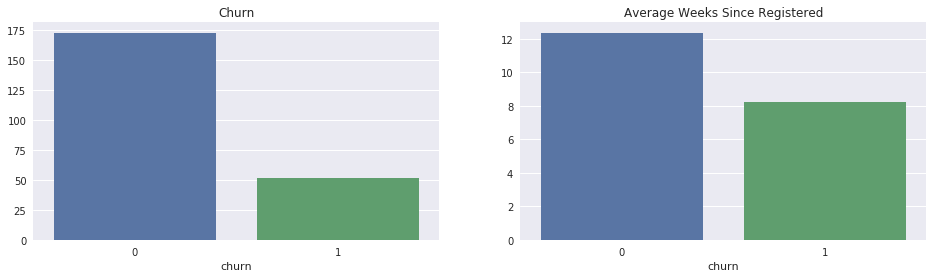

In [14]:
fig, axs = plt.subplots(1,2)
fig.set_figheight(4)
fig.set_figwidth(16)

# Data Visualisation
churnData = summaryData.groupby('churn').size()
weeksData = summaryData.groupby('churn').agg('weeksSinceRegistered').mean()
churnGenderData = summaryData.groupby(['churn', 'gender']).size()

# Plot
axs[0].set_title('Churn');
sns.barplot(x = churnData.index, y = churnData.values, ax = axs[0]);
axs[1].set_title('Average Weeks Since Registered');
sns.barplot(x = weeksData.index, y = weeksData.values, ax = axs[1]);

In [16]:
# Data visualisation - Views of pages and timeframe
pagesViews = sparkifyData.groupby('page').count().toPandas().sort_values(by = 'count', ascending = False)
weeklyActions = sparkifyData.groupBy('dataWeek').count().toPandas().sort_values(by = 'dataWeek', ascending = True)

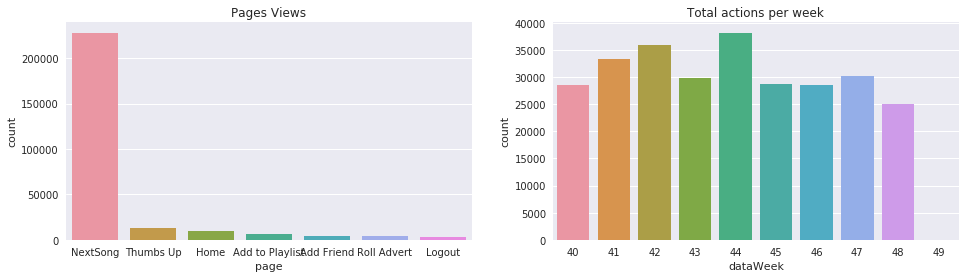

In [17]:
fig, axs = plt.subplots(1,2)
fig.set_figheight(4)
fig.set_figwidth(16)

# Plot
axs[0].set_title('Pages Views')
sns.barplot(x = pagesViews.page[:7], y = pagesViews['count'], ax = axs[0]);
axs[1].set_title('Total actions per week');
sns.barplot(x = weeklyActions.dataWeek, y = weeklyActions['count'], ax = axs[1]);

Because I will be creating an app for data visualisation, I'm limiting the data visualisation in this part as this will be done in the app.

In [18]:
# Total churn per week - Unique Sessions per week - Active users per week
weeklyData = sparkifyData.groupBy('dataWeek').agg(
        countDistinct(col("userId")).alias("uniqueUsers"),
        countDistinct(col("sessionId")).alias("uniqueSessions"),
        F.sum(col("churn")).alias("totalChurn")
).toPandas().sort_values(by="dataWeek")

In [19]:
# Save Datasets
weeklyData.to_csv('weeklyData.csv', index = False)

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

#### Feature Engineering Logic
Because the data that we have is on a action level (what a user is doing) and we need to make our predictions on a user level, we need to aggregate it. 

Directly aggregating the data will create a bias in the model as it is likely that users who churned will have less data and actions. Therefore, we need to find a comparable base for all users to train the model on.

The goal of this feature engineering is to build a set of features that show behaviour of users before they left. We will be using the change of behaviour from one week to the other before each user left.

If a user left in Week 3, we will be aggregating behaviour in Week 1 and Week 2 and then computing the change to try and predict if a user is likely to leave in week 3.

To be able to compare users who left to users who did not, I will be using the same logic for the users who did not. However, instead of having the churn week as the base, I will select a random week for the users and then compute the change.

***Limitations***

One limitation of this methodology is that we will need a minimum of 3 weeks data for every user. The two first weeks to create the features and the third week to find if a user churned or not. Therefore, I will remove the users that we do not have enough data for. To really measure the impact that this will have on the number of data points we will remove, we need to test it on the large dataset.


In [20]:
# Filter on users that we have enough data for
usersData = usersData.filter('distinctWeekData > 2')

In [21]:
# Create selection date. For each user, if they left we set the churn week as the selection week. If not, a random week is
# selected within the weeks that we have for that user.
setSelectionDate = udf(lambda x, y, z: x if x != 0 else random.randint(y + 2, z))
usersData = usersData.withColumn('dateSelection', setSelectionDate(usersData.churnWeek, usersData.minDataWeek, 
                                                                   usersData.maxDataWeek))

In [22]:
# Select the data that we need only
usersData = usersData.withColumn('weeksRegistered', usersData.dateSelection - usersData.registrationWeek)
usersData = usersData.select(['userId', 'gender', 'weeksRegistered', 'churn', 'dateSelection'])

In [23]:
# Dummy variables the pages
pages = ['Thumbs Down', 'Add to Playlist', 'Add Friend', 'Thumbs Up', 'Help', 'Upgrade', 'Error', 'Submit Upgrade']
exprs = [F.when(F.col("page") == page, 1).otherwise(0).alias(page) for page in pages]
dummyData = sparkifyData.select("*", *exprs)

# Computing weekly data per user and per week. Aggregating per week will allow me to select the metrics for the weeks 
# selected for each user.
weeklyData = dummyData.groupBy(['userId', 'dataWeek']).agg(
    countDistinct('sessionId').alias('distinctSession'), 
    countDistinct('song').alias('distinctSongs'),
    F.sum('length').alias('listenTime'),
    F.sum('Thumbs Down').alias('thumbsDown'),
    F.sum('Add to Playlist').alias('addToPlaylist'),
    F.sum('Add Friend').alias('addFriend'),
    F.sum('Thumbs Up').alias('thumbsUp'),
    F.sum('Help').alias('help'),
    F.sum('Error').alias('error'),
    F.sum('Submit Upgrade').alias('submitUpgrade')
)

In [24]:
# Creating names to differentiate between the first and second week.
originalNames = weeklyData.columns
weekOneColumns = [str(col) + '_weekOne' for col in weeklyData.columns]
weekTwoColumns = [str(col) + '_weekTwo' for col in weeklyData.columns]

In [25]:
# Setting Alias
usersData = usersData.alias('users')

# Updating column names for the first join
weekOneData = reduce(lambda weeklyData, idx: weeklyData.withColumnRenamed(originalNames[idx], weekOneColumns[idx]), 
                     range(len(originalNames)), weeklyData)

# Joining
joinWeekOne = usersData.join(weekOneData, (usersData.userId == weekOneData.userId_weekOne) & 
                             (usersData.dateSelection - 2 == weekOneData.dataWeek_weekOne), how = 'left'
                            ).drop('userId_weekOne','dataWeek_weekOne')

# Updating column names for the first join
weekTwoData = reduce(lambda weeklyData, idx: weeklyData.withColumnRenamed(originalNames[idx], weekTwoColumns[idx]), 
                     range(len(originalNames)), weeklyData)

# Joining
joinedDataSet = joinWeekOne.join(weekTwoData, (joinWeekOne.userId == weekTwoData.userId_weekTwo) & 
                             (joinWeekOne.dateSelection - 1 == weekTwoData.dataWeek_weekTwo), how = 'left'
                            ).drop('userId_weekTwo','dataWeek_weekTwo')

# We'll assume that null values in here mean that there was no activity by the user. Filling with 0
joinedDataSet = joinedDataSet.na.fill(0)

In [26]:
# Create function to compute change
def changeCalculation(start, end):
    if start == end:
        return float(0)
    elif start == 0 and end > 0:
        return float(1.0)
    else:
        return float((end - start)/start)

# Calculating change of columns
computeChange = udf(lambda start,end: changeCalculation(start, end), FloatType())
for column in originalNames:
    if column in ['userId', 'dataWeek']: continue
    # Create the new column and drop originals
    joinedDataSet = joinedDataSet.withColumn(column+'Change', computeChange(col(column+'_weekTwo'), col(column+'_weekOne')))\
                                .drop(column+'_weekOne', column+'_weekTwo')

In [27]:
# Map gender to 0 and 1.
mapGender = udf(lambda x: 1 if x == 'F' else 0, IntegerType())
joinedDataSet = joinedDataSet.withColumn('genderMap', mapGender(joinedDataSet.gender))

In [28]:
# Removing columns not to be used.
joinedDataSet = joinedDataSet.drop('weeksRegistered', 'dateSelection', 'gender', 'userId')

In [29]:
# Compute change
finalDataStats = joinedDataSet.groupBy('churn').mean().toPandas()

In [30]:
finalDataStats.drop('avg(churn)', axis = 1)

,churn,avg(distinctSessionChange),avg(distinctSongsChange),avg(listenTimeChange),avg(thumbsDownChange),avg(addToPlaylistChange),avg(addFriendChange),avg(thumbsUpChange),avg(helpChange),avg(errorChange),avg(submitUpgradeChange),avg(genderMap)
0,0,0.206662,1.063148,1.040300,0.212923,0.313775,0.049006,0.433309,0.071688,-0.012821,0.057692,0.487179
1,1,0.148842,0.535936,0.574203,0.040237,0.459896,0.465648,0.336325,0.204204,0.027027,0.135135,0.432432


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [31]:
# Define features and target
features = ['distinctSessionChange', 'distinctSongsChange', 'listenTimeChange', 'thumbsDownChange', 
            'addToPlaylistChange', 'addFriendChange', 'thumbsUpChange', 'helpChange', 'errorChange', 
            'submitUpgradeChange', 'genderMap']

# Features
assembler = VectorAssembler(inputCols=features, outputCol="modelFeatures")
transformedDataSet = assembler.transform(joinedDataSet)

# Scaling
scaler = StandardScaler(inputCol="modelFeatures", outputCol="features", withStd=True)
scalerModel = scaler.fit(transformedDataSet)
scaledData = scalerModel.transform(transformedDataSet)

# Select columns
sparkifyModifiedData = scaledData.select(col('churn').alias('label'), col('features'))

In [32]:
# split the full dataset into training and testing sets
trainData, testData, validationData = sparkifyModifiedData.randomSplit([0.70, 0.15, 0.15], seed=42)

# display shape of datasets
print(f'Training shape {trainData.count()}')
print(f'Testing shape {testData.count()}')
print(f'Validation shape {validationData.count()}')

Training shape 142
Testing shape 28
Validation shape 29


In [33]:
# Logistic Regression
print('Training Logistic Regression')
modelLR = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
modelLR = modelLR.fit(trainData)

# Decision Trees
print('Training Decision Tree Classifier')
modelDT = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label')
modelDT = modelDT.fit(trainData)

# Random Forest
print('Training Random Forest Classifier')
modelRF = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
modelRF = modelRF.fit(trainData)

# Gradient Boosting Trees
print('GBT Classifier')
modelGBT = GBTClassifier(featuresCol = 'features', labelCol = 'label')
modelGBT = modelGBT.fit(trainData)

Training Logistic Regression
Training Decision Tree Classifier
Training Random Forest Classifier
GBT Classifier


In [34]:
def evaluateModels(models, trainingSet, validationSet):
    f1Scorer = MulticlassClassificationEvaluator(metricName='f1')
    for model in models:
        print(model.__class__.__name__)
        trainPredictions = model.transform(trainingSet)
        validationPredictions = model.transform(validationSet)
        print('F1 Score Training: ', f1Scorer.evaluate(trainPredictions))
        print('F1 Score Validation: ', f1Scorer.evaluate(validationPredictions))

In [35]:
# Evaluation the model on the validation set
evaluateModels([modelLR, modelDT, modelRF, modelGBT], trainData, validationData)

LogisticRegressionModel
F1 Score Training:  0.7643027888446214
F1 Score Validation:  0.8034782608695652
DecisionTreeClassificationModel
F1 Score Training:  0.7553865391839529
F1 Score Validation:  0.7625994694960212
RandomForestClassificationModel
F1 Score Training:  0.7958527290778625
F1 Score Validation:  0.6248447204968944
GBTClassificationModel
F1 Score Training:  0.8705035971223022
F1 Score Validation:  0.8518518518518519


In [36]:
# Tune model
modelGBT = GBTClassifier()

# Printing all possible parameters
print({param[0].name: param[1] for param in modelGBT.extractParamMap().items()})

# Build parameters grid
parametersGBT = ParamGridBuilder().\
                    addGrid(modelGBT.maxDepth,[5, 10]).\
                    addGrid(modelGBT.stepSize, [0.1,0.01]).\
                    build()

# Create evaluator F1
evaluator = MulticlassClassificationEvaluator(metricName='f1')

# Training
crossValidationGbt = CrossValidator(estimator=modelGBT, estimatorParamMaps=parametersGBT, evaluator=evaluator)

{'seed': 7058364393524523576, 'predictionCol': 'prediction', 'labelCol': 'label', 'featuresCol': 'features', 'maxDepth': 5, 'maxBins': 32, 'minInstancesPerNode': 1, 'minInfoGain': 0.0, 'maxMemoryInMB': 256, 'cacheNodeIds': False, 'checkpointInterval': 10, 'lossType': 'logistic', 'maxIter': 20, 'stepSize': 0.1, 'subsamplingRate': 1.0, 'featureSubsetStrategy': 'all'}


In [38]:
# Training model and displaying performance
crossModelGbt = crossValidationGbt.fit(trainData)
crossModelGbt.avgMetrics

[0.7087478087723571,
 0.7099174428755912,
 0.7427259968523235,
 0.7291706138802494]

In [43]:
evaluateModels([crossModelGbt], trainData, validationData)

CrossValidatorModel
F1 Score Training:  0.9852551984877127
F1 Score Validation:  0.7347368421052631


### Conclusions

In this project, we looked at the use of PySpark to load, clean, engineer features, and train a model. Using PySpark gives the possibility to handle large volumes of data. The dataset that was used is a sample of a larger dataset that contains the interactions of users in a fictional music service similar to Spotify. Based on their behaviour, we needed to predict whether a user is going to churn or not. 

#### Feature Engineering

After cleaning the data to remove the rows that did not have any user assigned to them, we engineered a new set of features that show the change of behaviour of a user 2 weeks prior to their churn.

To achieve this, we set a 'date selection' for each user to extract their data. For the users who churned, this week was their last week using the service. For the users who stayed with Sparkify, the date was a random week. By doing this, we were able to see 2 weeks behaviour of users before they churned and compare it to users that did not churn. The predictions become more precise as we are predicting if a user is likely to churn in a week's time. 

The reason why I followed this methodology is that simply grouping the variables by user will lead to a bias as users who churned are likely to have less interactions, therefore, we will be including some of the information that happened after the user left into the model.

#### Modelling

For the modelling, we transformed the features into a vector before standardising them. The column 'label' is the output (churn) and the column 'features' is the features that we engineered. After doing that, the set was split into training, testing, and validation. However, one thing to consider here is that this made the training set even smaller than it already is. 

We selected a logistic regression, decision tree, random forest, and gradient boosting tree as the models of choice. The best model was a gradient boosting and achieved an F1 score of 85% on the validation set.

#### Areas for Improvement

Even though the results of the initial runs look promising, we need to take into consideration the number of data points that are used for this. We won't be able to get a good representation until we use the large dataset and train the model. We also need to include the validation set in the cross validation model as the model was overfitting and reached an almost perfect F-score on the training set while dropping the performance on the validation set.

Once using the larger data, we might start seeing a decline in the performance as we will have more variance. However, we can tackle this by looking into new models and tune the model even further.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.